In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd
import salem

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
def linear_trend_lingress(x, nb_missing=None, sig=None):
    
    
    coll = []
    x = x.squeeze()

    for xx in x.transpose():
    
        slope, intercept, r, p, std_err = stats.linregress(np.arange(len(xx.values)), xx.values)

        # we need to return a dataarray or else xarray's groupby won't be happy

        if nb_missing is not None:
            if np.nansum(xx.values==0)>=10:
                p = np.nan
                slope = np.nan
        
        if sig is not None:
            if p > sig:
                slope = np.nan
        
        coll.append(slope)
    
    return xr.DataArray(coll,)

In [5]:
def linear_trend_lingress_2d(x, nb_missing=None, sig=None, method=None):
    
    
    # stack lat and lon into a single dimension called allpoints
    datastacked = x.stack(allpoints=['level', 'latitude'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_lingress,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = np.nan
            
    return dtrend['slope']

In [6]:
era_srfc = xr.open_dataset(cnst.ERA5_MONTHLY_SRFC_SYNOP)
era_pl = xr.open_dataset(cnst.ERA5_MONTHLY_PL_SYNOP)

In [7]:
era_pl = uda.flip_lat(era_pl)
era_srfc = uda.flip_lat(era_srfc)

In [8]:
s1=-12
s2=9

ar50 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-50_monthly_count.nc')
ar70 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_count_5000km2.nc')
ar40 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-40_monthly_count_-40base_1000km2.nc')

In [9]:
era_trend = era_pl.sel(longitude=slice(s1,s2), latitude=slice(3.5,15)).mean('longitude').squeeze()
era_trend2d = era_srfc.sel(longitude=slice(s1,s2), latitude=slice(3.5,15)).mean('longitude').squeeze()

ccover_trend = ar70['tir'].sel(lon=slice(s1,s2), lat=slice(4.5,14.5))/30
ccover_trend40 = ar40['tir'].sel(lon=slice(s1,s2), lat=slice(4.5,14.5))/30
ccover_trend50 = ar50['tir'].sel(lon=slice(s1,s2), lat=slice(4.5,14.5))/30
ccover_trend = ccover_trend.mean('lon').squeeze()*100
ccover_trend40 = ccover_trend40.mean('lon').squeeze()*100
ccover_trend50 = ccover_trend50.mean('lon').squeeze()*100

/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
ctrend = ccover_trend[ccover_trend['time.year']>1984].groupby('time.month').apply(linear_trend_lingress,nb_missing=10)*10
ctrend40 = ccover_trend40[ccover_trend40['time.year']>1984].groupby('time.month').apply(linear_trend_lingress,nb_missing=10)*10
ctrend50 = ccover_trend50[ccover_trend50['time.year']>1984].groupby('time.month').apply(linear_trend_lingress,nb_missing=10)*10

In [11]:
era_pl['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_cross =  era_pl.groupby(grouped).mean(dim='time')

In [12]:
era_srfc['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_srfc['time.month'].values,era_srfc['time.hour'].values)])
grouped='ymonth'
era_srfc_cross =  era_srfc.groupby(grouped).mean(dim='time')

/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [13]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(ax, data, lon, lat, title=None, xlabel=None, ylabel=None,  cmap=None,mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, cbar=True,**kwargs):

    mapp = ax.contourf(lon, lat, data, extend='both', alpha=0.75, cmap=cmap, **kwargs)  # this is the actual plot
    
#     cmapp = uplot.discrete_cmap(25, base_cmap=cmap)
#     mapp = ax.pcolormesh(lon, lat,data,cmap=cmapp, vmin=50, vmax=68)
    
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], width=0.002)
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'], linewidths=0.8 )
        plt.clabel(cs, inline=1, fontsize=10)
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if cbar:
        cbar = plt.colorbar(mapp, pad=0.09, format='%d')  # adds colorbar
        #cbar = plt.colorbar(mapp, ticks=np.linspace(50,68,25), pad=0.09)
        cbar.set_label(cbar_label)
    
    #return mapp


In [17]:
def sel_month(m1):

    cross_march = era_pl_cross.sel(ymonth=str(m1)+'-12').mean('longitude')
    cross_marchs = era_srfc_cross.sel(ymonth=str(m1)+'-12').mean('longitude')
    cross_m_shear = cross_march.sel(level=650)-cross_march.sel(level=900)
    
    cross_mse = u_met.moist_static_energy(cross_march['t'].values-273.15, cross_march['q'].values, geop=cross_march['z'].values)
    cross_dse = u_met.dry_static_energy(cross_march['t'].values-273.15, geop=cross_march['z'].values)
    cross_theta = u_met.theta(era_pl_cross.level.values, cross_march['t'].values-273.15)
    cross_theta_e = u_met.theta_e(era_pl_cross.level.values, cross_march['t'].values-273.15, cross_march['q'].values)
    
    cross_70_march = ctrend.sel(month=m1)
    cross_50_march = ctrend50.sel(month=m1)
    cross_40_march = ctrend40.sel(month=m1)
    
    return {
       'ERA_pl' : cross_march,
        'ERA_srfc' : cross_marchs,
        'ERA_shear' : cross_m_shear,
        'cover70' : cross_70_march,
        'cover50' : cross_50_march,       
        'cover40' : cross_40_march,  
        'mse' : cross_mse,
        'dse' : cross_dse,
        'theta' : cross_theta,
        'theta_e' : cross_theta_e
    }

In [21]:
ctrend[ctrend['month']==3]

<xarray.DataArray (month: 1, dim_0: 143)>
array([[ 2.143035e-01,  2.008309e-01,  2.447279e-01,  2.983963e-01,
         3.879670e-01,  4.899741e-01,  5.947569e-01,  5.784344e-01,
         5.775831e-01,  6.473890e-01,  6.784056e-01,  7.409941e-01,
         7.758970e-01,  8.141682e-01,  8.439264e-01,  7.651264e-01,
         7.876671e-01,  7.522830e-01,  7.284839e-01,  7.105327e-01,
         7.158995e-01,  7.153443e-01,  6.730018e-01,  6.970230e-01,
         6.744824e-01,  6.550507e-01,  6.823660e-01,  7.126054e-01,
         7.129385e-01,  6.849198e-01,  6.611577e-01,  6.651180e-01,
         7.126055e-01,  7.837068e-01,  8.228293e-01,  7.740094e-01,
         7.588712e-01,  8.061736e-01,  7.856685e-01,  7.732691e-01,
         7.739355e-01,  8.138351e-01,  8.586944e-01,  8.663932e-01,
         9.484874e-01,  9.447119e-01,  9.477099e-01,  8.928942e-01,
         9.727305e-01,  9.519665e-01,  8.997786e-01,  8.676145e-01,
         8.340441e-01,  7.944404e-01,  7.987710e-01,  7.777107e-01,
      

/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


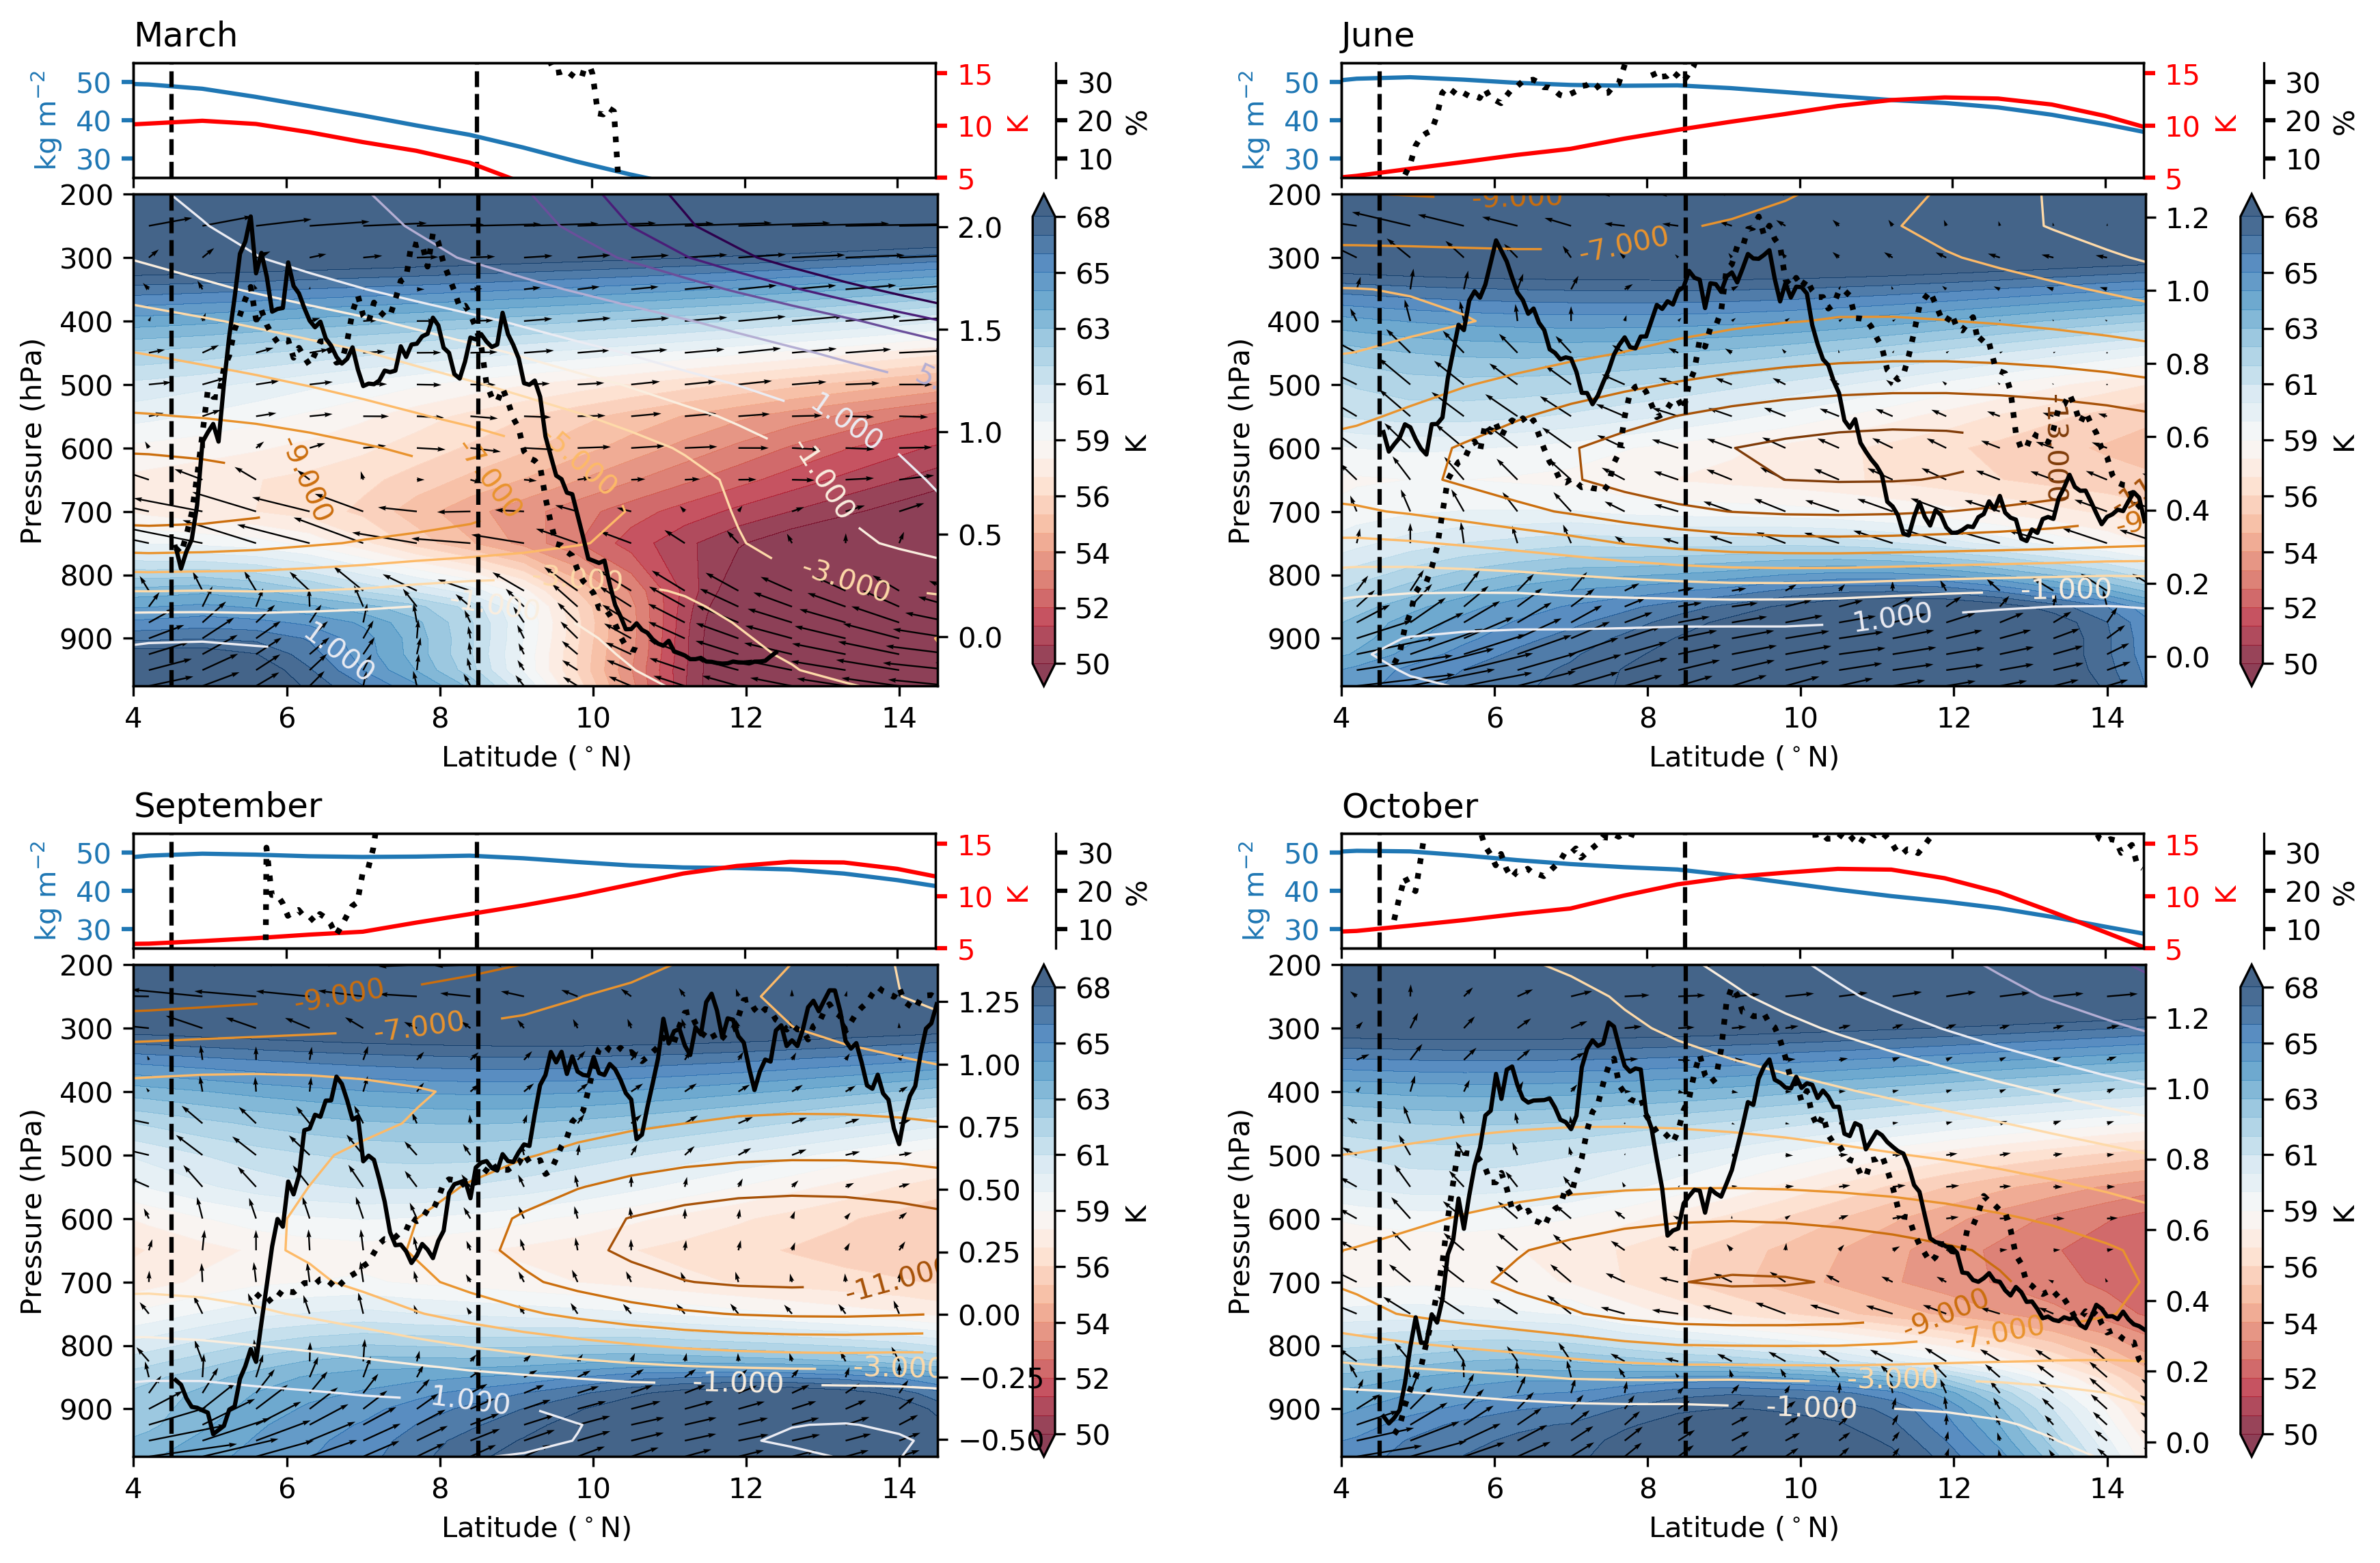

In [23]:

f=plt.figure(figsize=(12,8), dpi=300)  # this opens a plot window

left, width, width2 = 0.061, 0.43, 0.326#0.345
space=0.01
left2 = left + width + left

bottom, height, height2 = 0.07, 0.3, 0.07
bottom1 = bottom + height + space


bottom2 = bottom+height + height2 + space*10
bottom22 = bottom2  + height + space

cross1 = [left, bottom, width, height]
cross2 = [left+width+left, bottom, width, height]
line1 = [left, bottom1, width2, height2]
line2 = [left+width+left, bottom1, width2, height2]

cross3 = [left, bottom2, width, height]
cross4 = [left+width+left, bottom2, width, height]
line3 = [left, bottom22, width2, height2]
line4 = [left+width+left, bottom22, width2, height2]

pdic = {3 : (cross3,line3,'March'), 6 : (cross4, line4,'June'), 9 : (cross1, line1,'September'), 10 : (cross2, line2,'October') }

for k in pdic.keys():#ids, m in enumerate(np.array([3,6,9,10])):
    
    m = k
    p1 = pdic[k][0]
    p2 = pdic[k][1]
    mname = pdic[k][2]
    

    ylabel = 'Pressure (hPa)'
    cbar=True
    xlabel = r'Latitude ($^\circ$N)'
    
    vdic = sel_month(m)

#     ax = plt.axes(p1)#f.add_subplot(2,2,ids+1)
#     t2 = np.repeat(vdic['ERA_srfc']['t2m'].values, repeats = len(vdic['ERA_pl'].level), axis=0).reshape((len(vdic['ERA_srfc']['t2m'].values), len(vdic['ERA_pl'].level))).T
#     cs = ax.contour(vdic['ERA_srfc'].latitude,vdic['ERA_pl'].level, t2-273.15, levels=np.arange(25,36,1))
#     plt.clabel(cs, inline=1, fontsize=10)
    
    # "current zonal wind" wind vectors
    vano = vdic['ERA_pl']['v']
    wano = vdic['ERA_pl']['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
    st=1
    sarrow = 1
    xquiv = vdic['ERA_pl'].latitude[sarrow::st]
    yquiv = vdic['ERA_pl'].level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}
    #
    # temperature and moisture check
    data = (vdic['ERA_pl']['u'])
    data2 = vdic['theta_e']
    #data2 = (vdic['ERA_pl']['r'])
    ax = plt.axes(p1)
    contour = {'data' : data, 'x' : vdic['ERA_pl'].latitude, 'y' : vdic['ERA_pl'].level, 'levels' : [-13,-11,-9,-7,-5,-3,-1,1,5,9,11,13], 'cmap' : 'PuOr'}
    draw_cross(ax, data2, vdic['ERA_pl'].latitude, vdic['ERA_pl'].level, cmap='RdBu', 
               levels=np.linspace(50,68,25), quiver=qin, contour=contour, cbar_label='K', cbar=cbar, xlabel=xlabel, ylabel=ylabel)
    ax.set_xlim(4,14.5)
    ax2 = ax.twinx()
    ax2.plot(ccover_trend.lat,vdic['cover50'].values/np.nansum(vdic['cover50'].values)*100, 'k-')
    ax2.plot(ccover_trend.lat,vdic['cover70'].values/np.nansum(vdic['cover70'].values)*100, color='k',  linestyle='dotted', linewidth=2)
    #ipdb.set_trace()
    plt.axvline(x=4.5, color='k', linestyle='dashed')
    plt.axvline(x=8.5, color='k', linestyle='dashed')

    ##############################################
    ax1 = plt.axes(p2)
    ax1.set_xticklabels([])

    pl1, = ax1.plot(vdic['ERA_pl'].latitude,vdic['ERA_srfc']['tcwv'])
    plt.axvline(x=4.5, color='k', linestyle='dashed')
    plt.axvline(x=8.5, color='k', linestyle='dashed')
    ax1.set_title(mname, loc='left', fontsize=12)
    
    ax1.set_ylim(25,55)
    ax1.set_xlim(4,14.5)
    ax5 = ax1.twinx()

    
    pl5, = ax5.plot(vdic['ERA_pl'].latitude, vdic['theta_e'][15:18,:].mean(axis=0)-vdic['theta_e'][8:11,:].mean(axis=0), '-r')
    ax5.set_ylim(5,16)
    

    
    ax6 = ax1.twinx()
    
    pl6, = ax6.plot(ccover_trend.lat,vdic['cover70'].values/vdic['cover50'].values*100, color='k', linestyle='dotted', linewidth=2)
    ax6.set_ylim(5,35)
    
    
    ax1.yaxis.label.set_color(pl1.get_color())
    ax5.yaxis.label.set_color(pl5.get_color())
    ax6.yaxis.label.set_color(pl6.get_color())
    
    tkw = dict(size=4, width=1.5)
    ax1.tick_params(axis='y', colors=pl1.get_color(), **tkw)
    ax5.tick_params(axis='y', colors=pl5.get_color(), **tkw)
    ax6.tick_params(axis='y', colors=pl6.get_color(), **tkw)
    
 
    ax6.spines["right"].set_position(("axes", 1.15))
    ax6.set_ylabel('%')
    ax5.set_ylabel('K')
    ax1.set_ylabel(r'kg m$^{-2}$')
    
#plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/CLOVER/paper1/fig3.jpg')

In [ ]:

f=plt.figure(figsize=(12,9), dpi=300)  # this opens a plot window

left, width, width2 = 0.061, 0.43, 0.326#0.345
space=0.014
left2 = left + width + left

bottom, height, height2 = 0.09, 0.35, 0.07
bottom1 = bottom + height + space


bottom2 = bottom+height + height2 + space*8
bottom22 = bottom2  + height + space

cross1 = [left, bottom, width, height]
cross2 = [left+width+left, bottom, width, height]
line1 = [left, bottom1, width2, height2]
line2 = [left+width+left, bottom1, width2, height2]

cross3 = [left, bottom2, width, height]
cross4 = [left+width+left, bottom2, width, height]
line3 = [left, bottom22, width2, height2]
line4 = [left+width+left, bottom22, width2, height2]

pdic = {4 : (cross3,line3, 'April'), 5 : (cross4, line4, 'Mai'), 8 : (cross1, line1, 'August'), 11 : (cross2, line2, 'November') }

for k in pdic.keys():#ids, m in enumerate(np.array([3,6,9,10])):
    
    m = k
    p1 = pdic[k][0]
    p2 = pdic[k][1]
    mname = pdic[k][2]
    
    vdic = sel_month(m)

#     ax = plt.axes(p1)#f.add_subplot(2,2,ids+1)
#     t2 = np.repeat(vdic['ERA_srfc']['t2m'].values, repeats = len(vdic['ERA_pl'].level), axis=0).reshape((len(vdic['ERA_srfc']['t2m'].values), len(vdic['ERA_pl'].level))).T
#     cs = ax.contour(vdic['ERA_srfc'].latitude,vdic['ERA_pl'].level, t2-273.15, levels=np.arange(25,36,1))
#     plt.clabel(cs, inline=1, fontsize=10)
    
    # "current zonal wind" wind vectors
    vano = vdic['ERA_pl']['v']
    wano = vdic['ERA_pl']['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
    st=1
    sarrow = 1
    xquiv = vdic['ERA_pl'].latitude[sarrow::st]
    yquiv = vdic['ERA_pl'].level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

    # temperature and moisture check
    data = (vdic['ERA_pl']['u'])
    data2 = vdic['theta_e']
    #data2 = (vdic['ERA_pl']['r'])
    ax = plt.axes(p1)
    contour = {'data' : data, 'x' : vdic['ERA_pl'].latitude, 'y' : vdic['ERA_pl'].level, 'levels' : [-13,-11,-9,-7,-5,-3,-1,1,3,5,7,9,11,12,13], 'cmap' : 'PuOr'}
    draw_cross(ax, data2, vdic['ERA_pl'].latitude, vdic['ERA_pl'].level, cmap='RdBu', 
               levels=np.linspace(50,68,25), quiver=qin, contour=contour, cbar_label='K')
    
    ax2 = ax.twinx()
    ax2.plot(vdic['cover40'].lat,vdic['cover40'].values/np.sum(vdic['cover40'].values)*100, '-k')
    ax2.plot(vdic['cover70'].lat,vdic['cover70'].values/np.sum(vdic['cover70'].values)*100, '-r')
    

    plt.axvline(x=4.7, color='k', linestyle='dashed')
    plt.axvline(x=8.3, color='k', linestyle='dashed')

    ax1 = plt.axes(p2)#ax.twinx()
    ax1.set_xticklabels([])
    #ax1.plot(vdic['CHIRPS'].lat, vdic['CHIRPS']['precip'].values/np.sum(vdic['CHIRPS']['precip'].values)*100)
    #ax1.set_ylim(0,300)

    #ax2 = ax1.twinx()
    #ax2.spines["right"].set_position(("axes", 1.15))
#     f70 = vdic['cover70'].values/np.sum(vdic['cover70'].values)*100
#     f50 = vdic['cover50'].values/np.sum(vdic['cover50'].values)*100
#     ax1.plot(vdic['cover70'].lat, f70, '-ro')
    #ax2.plot(vdic['meanT_-50'].lat,vdic['meanT_-50'].values, '-ro')
    #ax2.set_ylim(0,0.18)

    #ax2 = ax.twinx()
    #ax2.spines["right"].set_position(("axes", 1.15))
    #ax1.plot(vdic['cover50'].lat, f50, '-go')
    #ax2.set_ylim(0,0.18)
    # ax3 = ax.twinx()
    # ax3.spines["right"].#set_position(("axes", 1.15))
    # ax3.plot(latbin,ext_frac_m, '-go')

    #ax4 = ax1.twinx()
     # ax4.spines["right"].set_position(("axes", 1.15))
    # ax4.plot(latbin,ext_abs_m, '-yo')
    pl1, = ax1.plot(vdic['ERA_pl'].latitude,vdic['ERA_srfc']['tcwv'])
    ax1.set_title(mname, loc='left', fontsize=12)
    ax1.set_ylabel(r'kg m$^{-2}$')
    ax1.set_ylim(25,55)
    ax5 = ax1.twinx()
    #ax5.spines["right"].set_position(("axes", 1.15))
    
    #ax7 = ax1.twinx()
    #pl7, = ax5.plot(vdic['ERA_pl'].latitude, vdic['ERA_pl']['q'].sel(level=slice(900,950)).mean('level')*1000, '-b')
    
    pl5, = ax5.plot(vdic['ERA_pl'].latitude, vdic['theta_e'][15:18,:].mean(axis=0)-vdic['theta_e'][8:11,:].mean(axis=0), '-r')
    ax5.set_ylim(5,16)
    ax5.set_ylabel('K')
    
    ax6 = ax1.twinx()
    ax6.spines["right"].set_position(("axes", 1.15))
    pl6, = ax6.plot(vdic['cover50'].lat,vdic['cover70'].values/vdic['cover50'].values*100, 'k', linestyle='dotted')
    ax6.set_ylim(0,35)
    ax6.set_ylabel('%')
    
    ax1.yaxis.label.set_color(pl1.get_color())
    ax5.yaxis.label.set_color(pl5.get_color())
    ax6.yaxis.label.set_color(pl6.get_color())
    
    tkw = dict(size=4, width=1.5)
    ax1.tick_params(axis='y', colors=pl1.get_color(), **tkw)
    ax5.tick_params(axis='y', colors=pl5.get_color(), **tkw)
    ax6.tick_params(axis='y', colors=pl6.get_color(), **tkw)
    
plt.tight_layout()

In [ ]:

f=plt.figure(figsize=(12,8), dpi=300)  # this opens a plot window

for ids, m in enumerate(np.array([3,6,9,10])):
    
    vdic = sel_month(m)

    ax = f.add_subplot(2,2,ids+1)

    # "current zonal wind" wind vectors
    vano = vdic['ERA_pl']['v']
    wano = vdic['ERA_pl']['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
    st=1
    sarrow = 1
    xquiv = vdic['ERA_pl'].latitude[sarrow::st]
    yquiv = vdic['ERA_pl'].level

    uu = (vano)[::, sarrow::st]  
    ww = (wano)[::, sarrow::st]

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

    # temperature and moisture check
    data = (vdic['ERA_pl']['u'])
    #data2 = np.array(vdic['theta'])-np.mean(vdic['theta'][10,:])
    data2 = (vdic['theta_e']+273.15)
    contour = {'data' : data, 'x' : vdic['ERA_pl'].latitude, 'y' : vdic['ERA_pl'].level, 'levels' : [-13,-12,-11,-9,-7,-5,-3,-1,1,3,5,7,9,11,12,13], 'cmap' : 'PuOr'}
    draw_cross(ax, data2, vdic['ERA_pl'].latitude, vdic['ERA_pl'].level, cmap='RdBu', 
               levels=np.linspace(320,350,25), quiver=qin, contour=contour, cbar_label='K')


    plt.axvline(x=4.7, color='k', linestyle='dashed')
    plt.axvline(x=8.3, color='k', linestyle='dashed')

    ax1 = ax.twinx()
    #ax1.spines["right"].set_position(("axes", 1.15))
    #ax1.plot(vdic['CHIRPS'].lat, (vdic['CHIRPS']['precip'].values)/np.sum(vdic['CHIRPS']['precip'].values)*100)
    #ax1.set_ylim(0,300)

    #ax2 = ax.twinx()
    #ax2.spines["right"].set_position(("axes", 1.15))
    #ax1.plot(vdic['cover70'].lat,vdic['cover70'].values/np.sum(vdic['cover70'].values)*100, '-ko')
    #ax2.set_ylim(0,0.18)

    #ax2 = ax.twinx()
    #ax2.spines["right"].set_position(("axes", 1.15))
    ax1.plot(vdic['cover40'].lat,vdic['cover40'].values/np.sum(vdic['cover40'].values)*100, '-k')
    ax1.plot(vdic['cover70'].lat,vdic['cover70'].values/np.sum(vdic['cover70'].values)*100, '-r')
#     f70 = vdic['cover70'].values/np.sum(vdic['cover70'].values)*100
#     f50 = (vdic['cover40'].values/np.sum(vdic['cover40'].values))*100
    
#     perc = (vdic['cover70'].values / vdic['cover40'].values) * 100
#     avg_perc = np.sum(vdic['cover70'].values) / np.sum(vdic['cover40'].values) * 100

    #ax1.plot(vdic['cover50'].lat, perc-avg_perc, '-kx')
#     ax1.set_ylim(-10,10)
    # ax3 = ax.twinx()
    # ax3.spines["right"].#set_position(("axes", 1.15))
    # ax3.plot(latbin,ext_frac_m, '-go')

    # ax4 = ax.twinx()
    # ax4.spines["right"].set_position(("axes", 1.15))
    # ax4.plot(latbin,ext_abs_m, '-yo')

#     ax4 = ax.twinx()
#     ax4.spines["right"].set_position(("axes", 1.15))
#     ax4.plot(latbin,np.array(vdic['extreme70Frac50'])*100, '-ro')
plt.tight_layout()

In [ ]:
perc

In [ ]:
np.sum(vdic['cover50'].values)

In [ ]:
vdic['cover50'].values / np.sum(vdic['cover50'].values)